<div style="background:#F5F7FA; height:100px; padding: 2em; font-size:14px;">
<span style="font-size:18px;color:#152935;">Want to do more?</span><span style="border: 1px solid #3d70b2;padding: 15px;float:right;margin-right:40px; color:#3d70b2; "><a href="https://ibm.co/wsnotebooks" target="_blank" style="color: #3d70b2;text-decoration: none;">Sign Up</a></span><br>
<span style="color:#5A6872;"> Try out this notebook with your free trial of IBM Watson Studio.</span>
</div>

<table style="border: none" align="left">
   <tr style="border: none">
      <th style="border: none"><font face="verdana" size="4" color="black"><b>Style transfer experiments with Watson Machine Learning client</b></font></th>
      <th style="border: none"><img src="https://github.com/pmservice/customer-satisfaction-prediction/blob/master/app/static/images/ml_icon_gray.png?raw=true" alt="Watson Machine Learning icon" height="40" width="40"></th>
   </tr> 
   <tr style="border: none">
       <td style="border: none"><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/1513px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg" width="500" alt="Icon"></td>
   </tr>
</table>

This notebook demonstrates style transfer technique using Watson Machine Learning Service, introducing commands for getting data, training_definition persistance to the Watson Machine Learning repository, and model training.

Some familiarity with Python is helpful. This notebook uses Python 3 on Spark 2.1.


## Learning goals

The learning goal of this notebook is to work with Watson Machine Learning experiments to train Deep Learning models (Keras).


## Contents

This notebook contains the following parts:

1.	[Setup](#setup)
2.	[Training definition](#definition)
3.	[Experiment definition](#experiment)
4.	[Experiment Run](#run)
5.	[Deploy and Score](#scoring)
6.	[Summary and next steps](#summary)

<a id="setup"></a>
## 1. Setup

Before you use the sample code in this notebook, you must perform the following setup tasks:

1. Create a <a href="https://console.ng.bluemix.net/catalog/services/ibm-watson-machine-learning/" target="_blank" rel="noopener no referrer">Watson Machine Learning Service</a> instance (a lite plan is offered). 
2. Create <a href="https://console.bluemix.net/catalog/infrastructure/cloud-object-storage" target="_blank" rel="noopener no referrer">Cloud Object Storage (COS)</a> instance (a lite plan is offered).
3. After you create a COS instance, go to your COS dashboard.
4. In **Service credentials** tab, click **New Credential**,
5. Add the inline configuration parameter: {"HMAC":true}, click **Add**.

    This configuration parameter adds the section below to instantiate credentials which will be used later on:
    ```
      "cos_hmac_keys": {
            "access_key_id": "<your access_key_id>",
            "secret_access_key": "<your secret_access_key>"
       }
    ```

### 1.1 Work with Cloud Object Storage

Import the Boto library, which allows Python developers to manage Cloud Object Storage.

In [1]:
import ibm_boto3
from ibm_botocore.client import Config
import os
import json
import warnings
import urllib
import time
warnings.filterwarnings('ignore')

We define the endpoint we will use. You can find this information in the **Endpoint** section of your Cloud Object Storage instance's dashbord.

In [2]:
cos_credentials = {
  "apikey": "***",
  "cos_hmac_keys": {
    "access_key_id": "***",
    "secret_access_key": "***"
  },
  "endpoints": "https://cos-service.bluemix.net/endpoints",
  "iam_apikey_description": "***",
  "iam_apikey_name": "***",
  "iam_role_crn": "crn:v1:bluemix:public:iam::::serviceRole:Writer",
  "iam_serviceid_crn": "***",
  "resource_instance_id": "***"
}

api_key = cos_credentials['apikey']
service_instance_id = cos_credentials['resource_instance_id']
auth_endpoint = 'https://iam.bluemix.net/oidc/token'
service_endpoint = 'https://s3-api.us-geo.objectstorage.softlayer.net'

Provide `type`, `endpoint_url` and credentials to create the Boto resource.

In [3]:
cos = ibm_boto3.resource('s3',
                         ibm_api_key_id=api_key,
                         ibm_service_instance_id=service_instance_id,
                         ibm_auth_endpoint=auth_endpoint,
                         config=Config(signature_version='oauth'),
                         endpoint_url=service_endpoint)

Let's create the buckets we will use to store training data and training results.

**Note:** The bucket name must be unique - please rename the buckets below with a unique name.

In [4]:
buckets = ['style-data-example', 'style-results-example']
for bucket in buckets:
    if not cos.Bucket(bucket) in cos.buckets.all():
        print('Creating bucket "{}"...'.format(bucket))
        try:
            cos.create_bucket(Bucket=bucket)
        except ibm_boto3.exceptions.ibm_botocore.client.ClientError as e:
            print('Error: {}.'.format(e.response['Error']['Message']))

Now we should have created 2 new buckets.

In [5]:
print(list(cos.buckets.all()))

[s3.Bucket(name='style-data-example'), s3.Bucket(name='style-data-lc'), s3.Bucket(name='style-results-example')]


### 1.2 Download the training data and upload it to COS buckets

Let's download our training data and upload them to the 'training-data' bucket.
We will create a list of links for the training data set.

The snippet below creates the `STYLE_DATA` folder and downloads the files from links.

**Tip:** First, install the wget library by running this command:
`!pip install wget`

In [6]:
import wget, os

data_dir = 'STYLE_DATA'
if not os.path.isdir(data_dir):
    os.mkdir(data_dir)

links = ['https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5',
         'https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/1513px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg',
         'https://upload.wikimedia.org/wikipedia/commons/5/52/Krak%C3%B3w_239a.jpg',
         'https://upload.wikimedia.org/wikipedia/commons/3/3f/Kandinsky%2C_Lyrisches.jpg']

for i in range(len(links)):
    if 'Gogh' in links[i]: 
        filepath = os.path.join(data_dir, 'van_gogh.jpg')
    elif 'Krak' in links[i]: 
        filepath = os.path.join(data_dir, 'krakow.jpg')
    elif 'Kandinsky' in links[i]:
        filepath = os.path.join(data_dir, 'kandinsky.jpg')
    else:
        filepath = os.path.join(data_dir, os.path.join(links[i].split('/')[-1]))

    if not os.path.isfile(filepath):
        print(links[i])
        urllib.request.urlretrieve(links[i], filepath)

        
!ls STYLE_DATA

kandinsky.jpg  van_gogh.jpg
krakow.jpg     vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5


#### Base image: Cracow - main market square

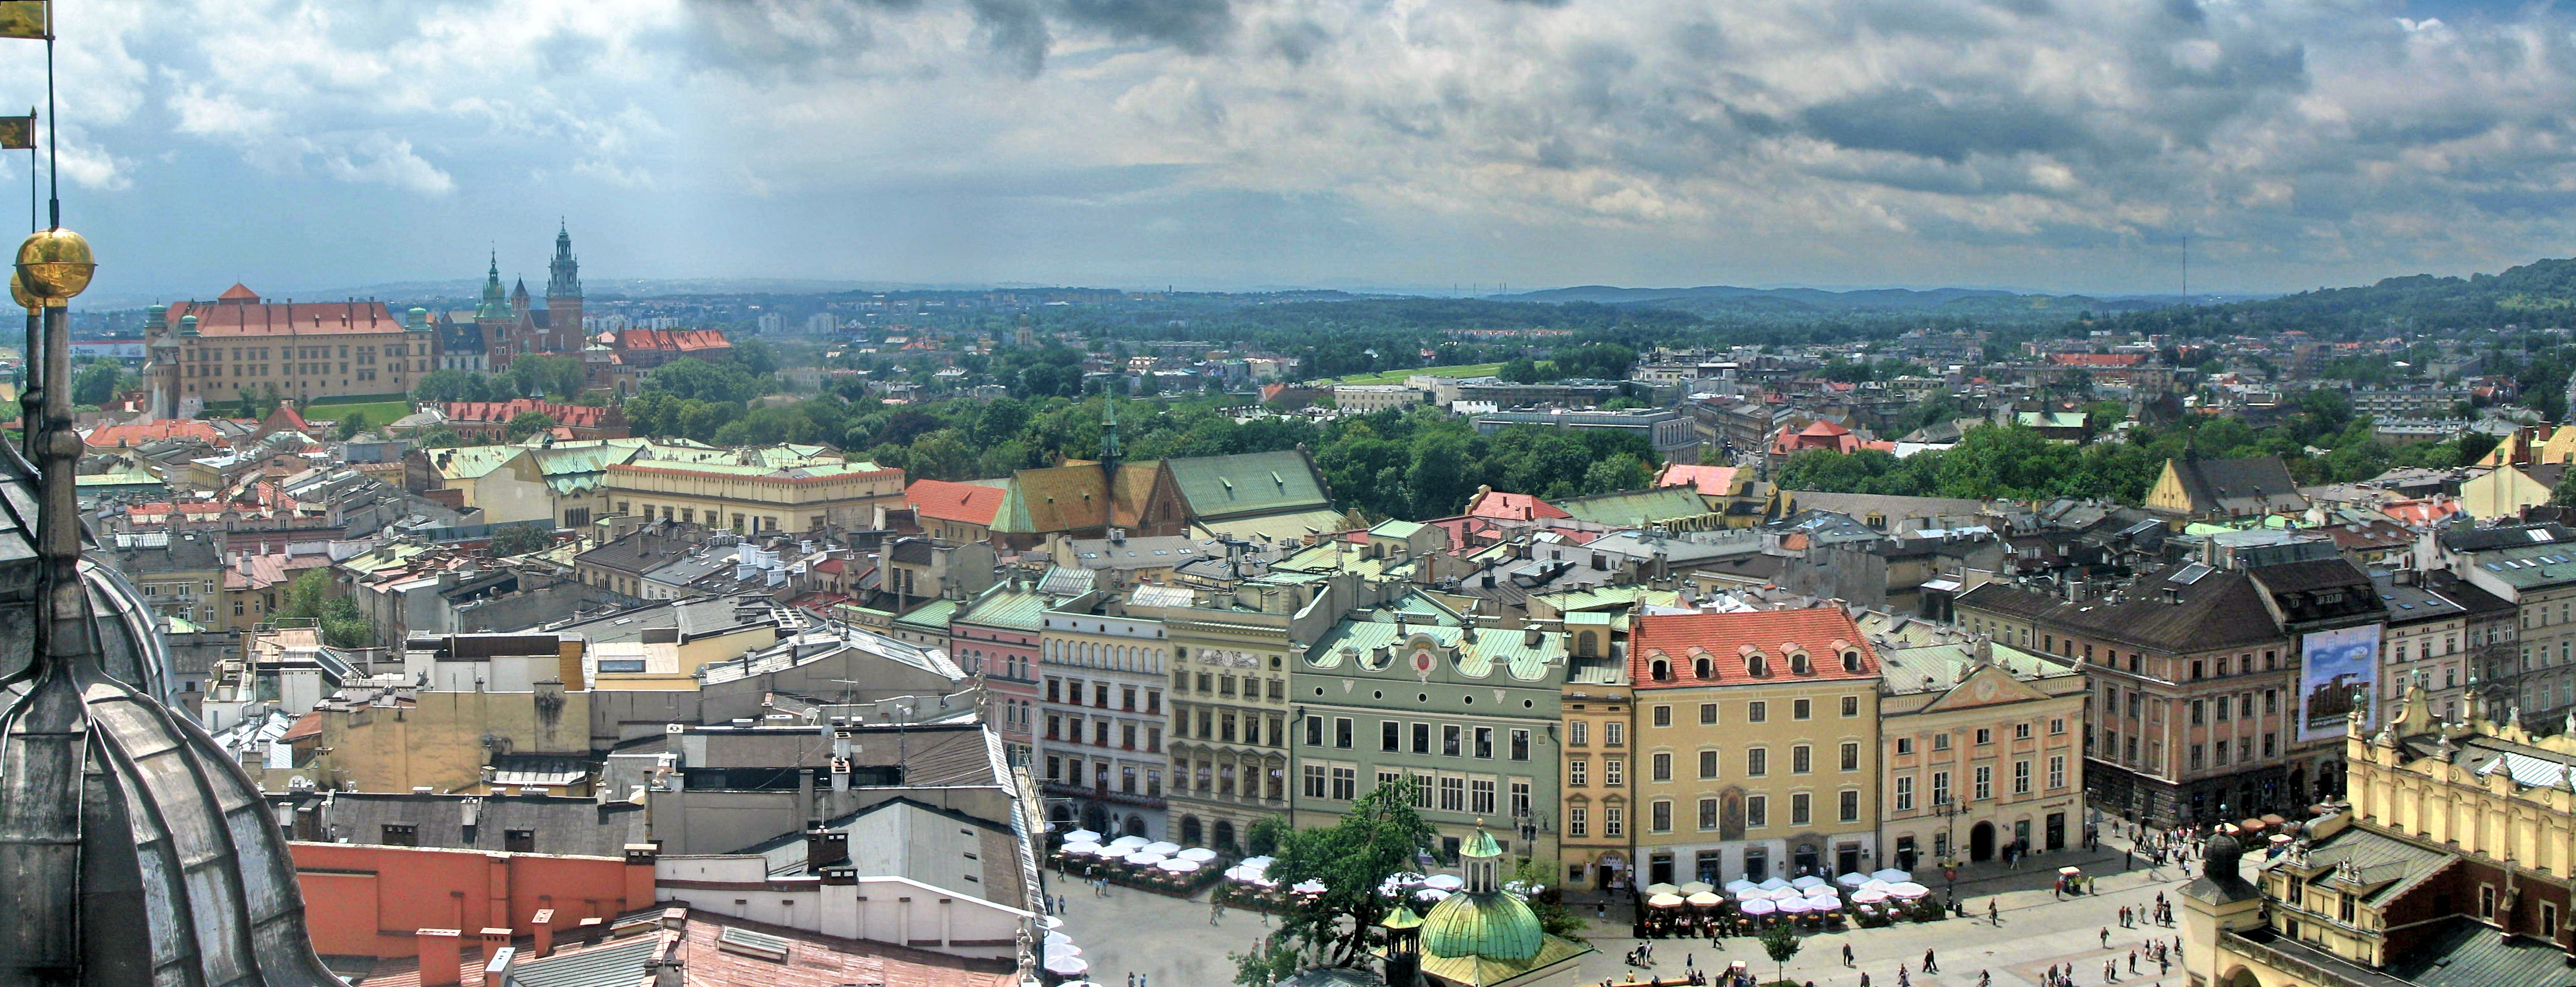

In [7]:
from IPython.display import Image
Image(filename=os.path.join(data_dir, 'krakow.jpg'), width=1000)

#### Style image 1: Vincent Van Gogh - Starry Night

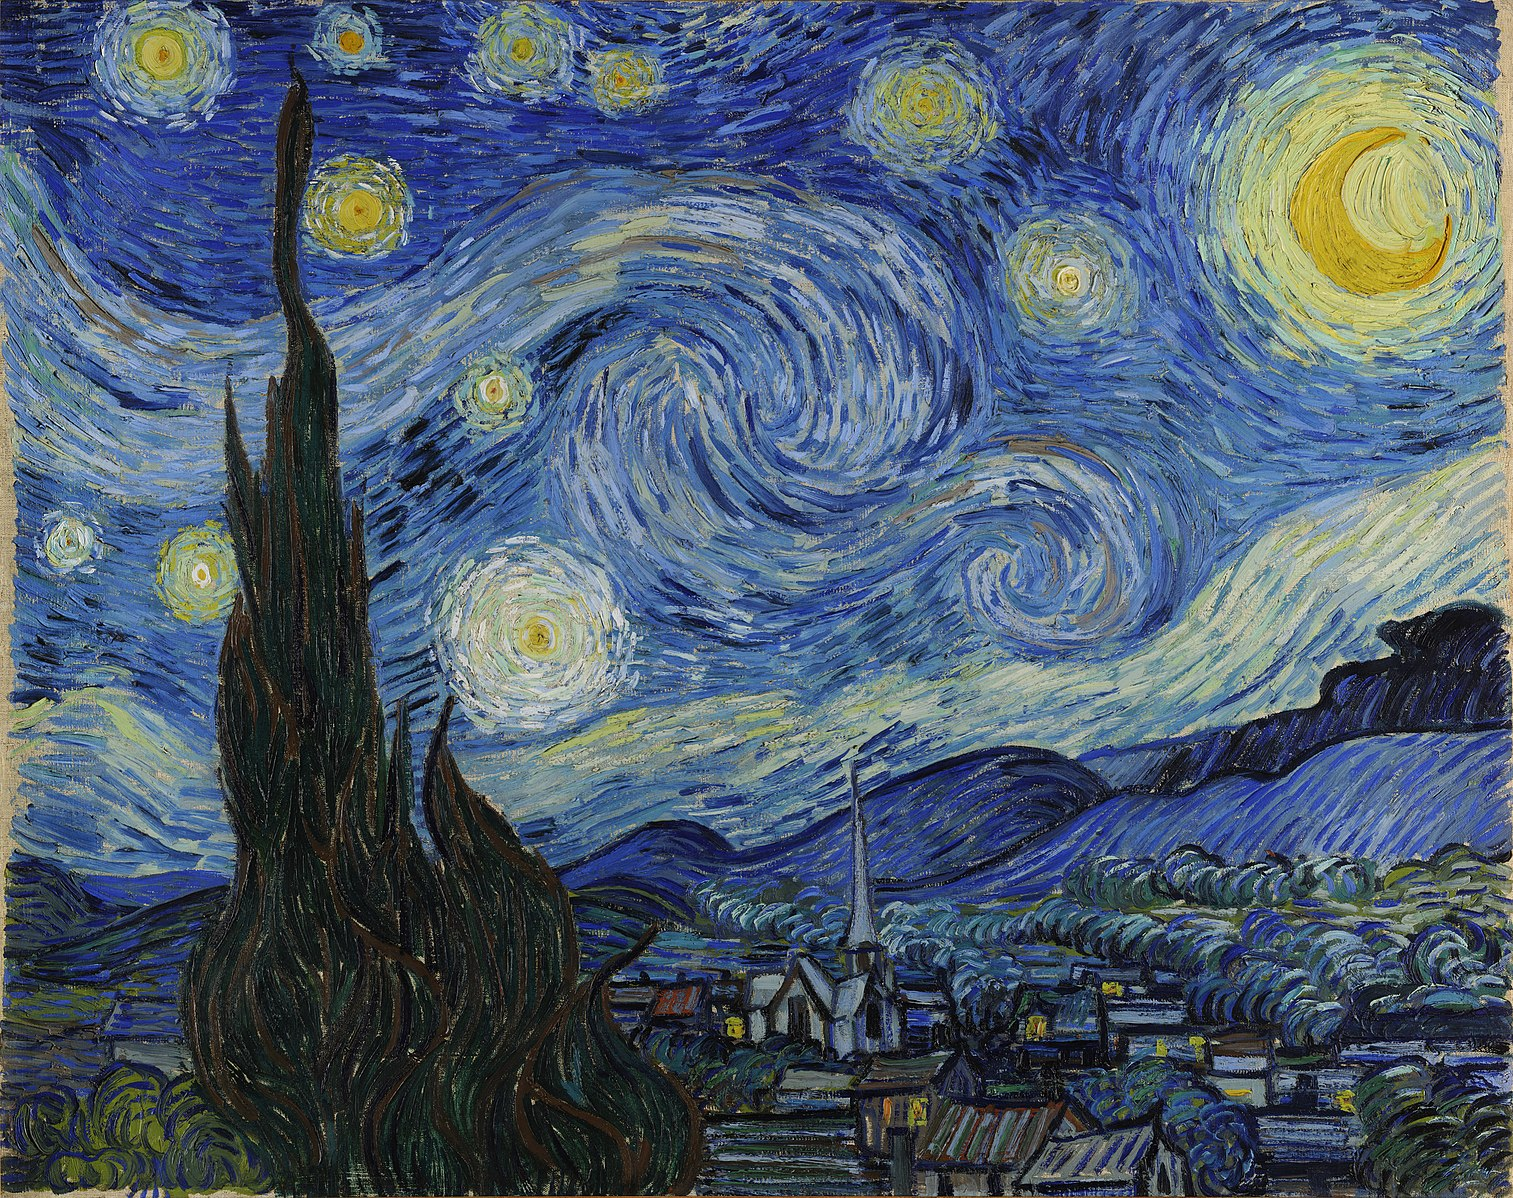

In [8]:
Image(filename=os.path.join(data_dir, 'van_gogh.jpg'), width=500)

<HR>

#### Style image 2: Kandinsky Lyrisches

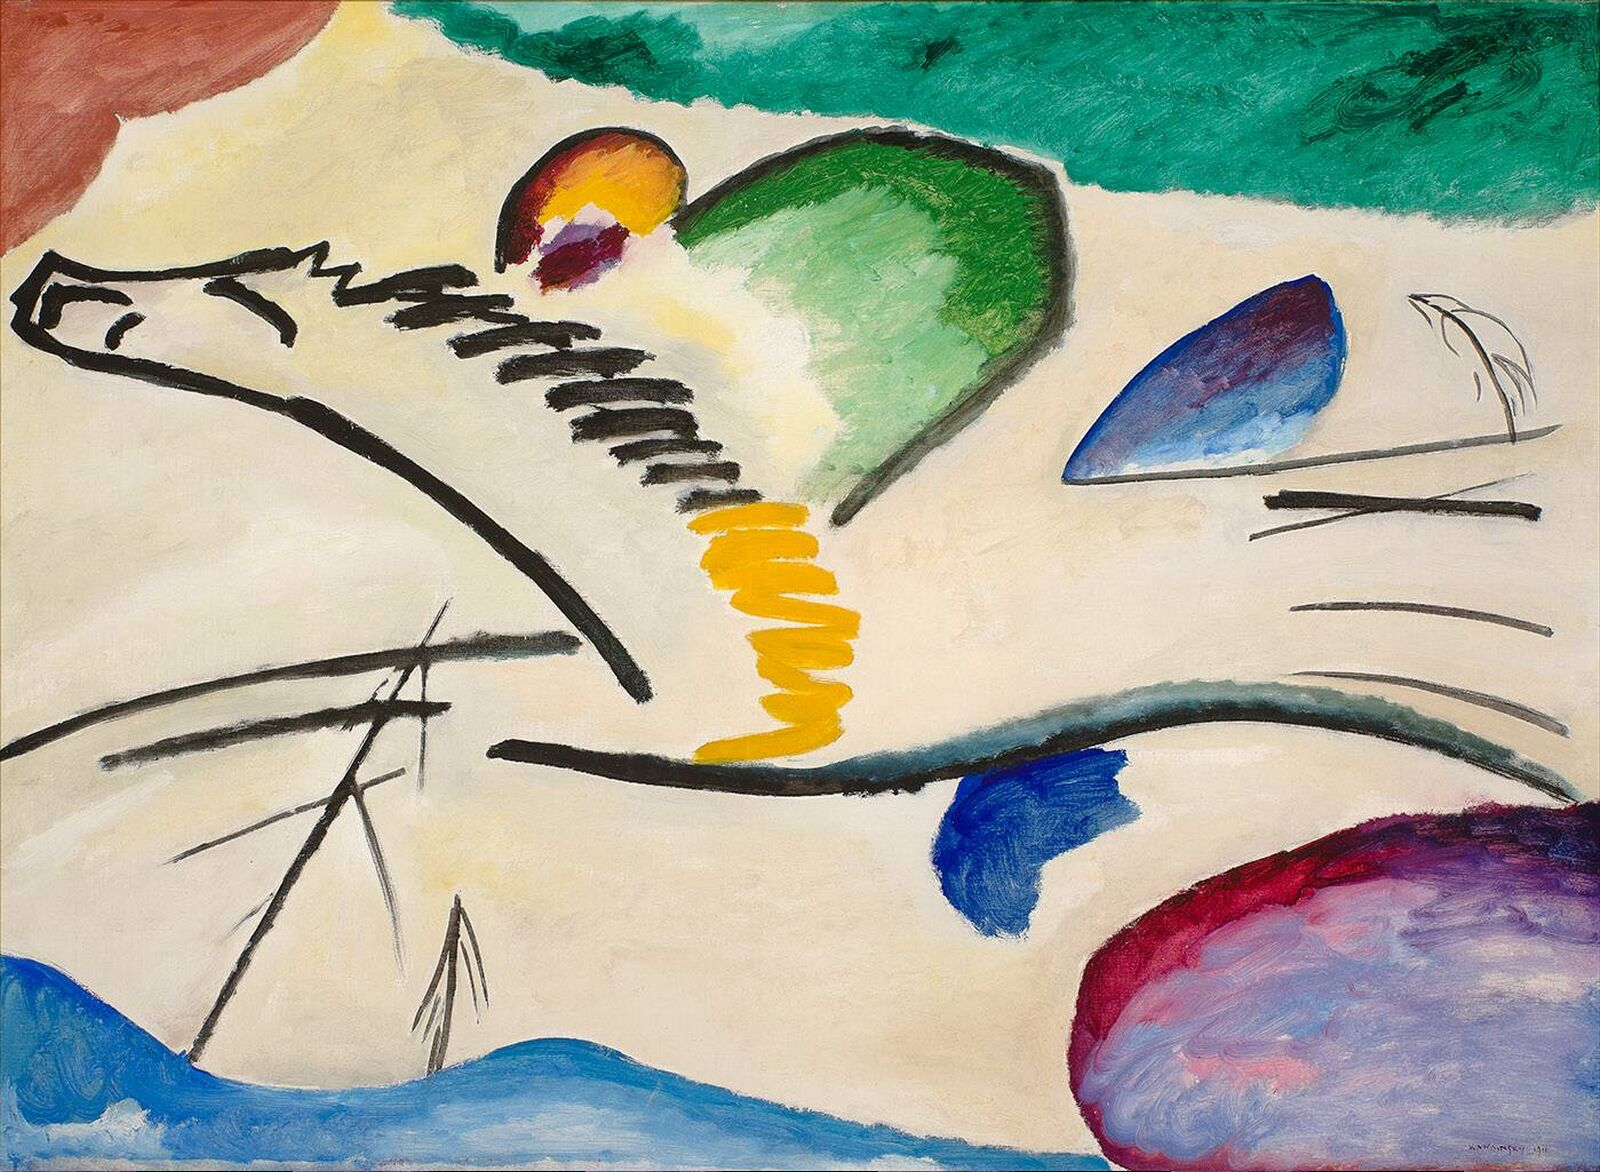

In [9]:
Image(filename=os.path.join(data_dir, 'kandinsky.jpg'), width=600)

Upload the data files to the created buckets.

In [10]:
bucket_name = buckets[0]
bucket_obj = cos.Bucket(bucket_name)

In [11]:
for filename in os.listdir(data_dir):
    with open(os.path.join(data_dir, filename), 'rb') as data: 
        bucket_obj.upload_file(os.path.join(data_dir, filename), filename)
        print('{} is uploaded.'.format(filename))

van_gogh.jpg is uploaded.
krakow.jpg is uploaded.
kandinsky.jpg is uploaded.
vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5 is uploaded.


Let's see the list of all the buckets and their contents.

In [12]:
for obj in bucket_obj.objects.all():
    print('Object key: {}'.format(obj.key))
    print('Object size (kb): {}'.format(obj.size/1024))

Object key: kandinsky.jpg
Object size (kb): 337.97265625
Object key: krakow.jpg
Object size (kb): 2063.50390625
Object key: van_gogh.jpg
Object size (kb): 833.9755859375
Object key: vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5
Object size (kb): 78256.46875


We are done with Cloud Object Storage, we are ready to train our model!

### 1.3 Work with the Watson Machine Learning instance

Authenticate to the Watson Machine Learning service on IBM Cloud.

In [13]:
import urllib3, requests, json, base64, time, os

**Action**: Put the authentication information from your instance of the Watson Machine Learning service here.

In [14]:
wml_credentials = {
  "url": "https://ibm-watson-ml.mybluemix.net",
  "access_key": "***",
  "username": "***",
  "password": "***",
  "instance_id": "***"
}

#### Install the `watson-machine-learning-client` from pypi

In [15]:
!rm -rf $PIP_BUILD/watson-machine-learning-client

In [16]:
!pip install --upgrade watson-machine-learning-client

Requirement already up-to-date: watson-machine-learning-client in /gpfs/global_fs01/sym_shared/YPProdSpark/user/sec7-2ac43fd194bc9a-8ef090487f81/.local/lib/python3.5/site-packages
Requirement already up-to-date: tqdm in /gpfs/global_fs01/sym_shared/YPProdSpark/user/sec7-2ac43fd194bc9a-8ef090487f81/.local/lib/python3.5/site-packages (from watson-machine-learning-client)
Requirement already up-to-date: tabulate in /usr/local/src/conda3_runtime.v28/home/envs/DSX-Python35-Spark/lib/python3.5/site-packages (from watson-machine-learning-client)
Requirement already up-to-date: urllib3 in /gpfs/global_fs01/sym_shared/YPProdSpark/user/sec7-2ac43fd194bc9a-8ef090487f81/.local/lib/python3.5/site-packages (from watson-machine-learning-client)
Requirement already up-to-date: certifi in /gpfs/global_fs01/sym_shared/YPProdSpark/user/sec7-2ac43fd194bc9a-8ef090487f81/.local/lib/python3.5/site-packages (from watson-machine-learning-client)
Requirement already up-to-date: pandas in /gpfs/global_fs01/sym_s

#### Import the `watson-machine-learning-client` and authenticate to the service instance

In [20]:
from watson_machine_learning_client import WatsonMachineLearningAPIClient

In [21]:
client = WatsonMachineLearningAPIClient(wml_credentials)

In [22]:
print(client.version)

1.0.11


<a id="definition"></a>
## 2. Create training definitions

#### Prepare the training definition metadata

**Hint:** The final effect depends on the number of iterations. Note that it has an impact on the training time.

In [24]:
iters = 1

In [25]:
model_definition_1_metadata = {
            client.repository.DefinitionMetaNames.NAME: "style transfer van gogh",
            client.repository.DefinitionMetaNames.AUTHOR_EMAIL: "JohnSmith@ibm.com",
            client.repository.DefinitionMetaNames.FRAMEWORK_NAME: "tensorflow",
            client.repository.DefinitionMetaNames.FRAMEWORK_VERSION: "1.5",
            client.repository.DefinitionMetaNames.RUNTIME_NAME: "python",
            client.repository.DefinitionMetaNames.RUNTIME_VERSION: "3.5",
            client.repository.DefinitionMetaNames.EXECUTION_COMMAND: "python style_transfer.py krakow.jpg van_gogh.jpg krakow --iter " + str(iters)
            }

In [26]:
model_definition_2_metadata = {
            client.repository.DefinitionMetaNames.NAME: "style transfer kandinsky",
            client.repository.DefinitionMetaNames.AUTHOR_EMAIL: "JohnSmith@ibm.com",
            client.repository.DefinitionMetaNames.FRAMEWORK_NAME: "tensorflow",
            client.repository.DefinitionMetaNames.FRAMEWORK_VERSION: "1.5",
            client.repository.DefinitionMetaNames.RUNTIME_NAME: "python",
            client.repository.DefinitionMetaNames.RUNTIME_VERSION: "3.5",
            client.repository.DefinitionMetaNames.EXECUTION_COMMAND: "python style_transfer.py krakow.jpg kandinsky.jpg krakow --iter " + str(iters)
            }

#### Get the sample model definition content files from git

In [27]:
!rm -rf STYLE.zip

In [28]:
filename_definition = 'STYLE.zip'

if not os.path.isfile(filename_definition):
    !wget https://github.com/pmservice/wml-sample-models/raw/master/keras/style/definition/STYLE.zip

!ls STYLE.zip

--2018-03-16 05:33:50--  https://github.com/pmservice/wml-sample-models/raw/master/keras/style/definition/STYLE.zip
Resolving github.com (github.com)... 192.30.253.112, 192.30.253.113
Connecting to github.com (github.com)|192.30.253.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/pmservice/wml-sample-models/master/keras/style/definition/STYLE.zip [following]
--2018-03-16 05:33:50--  https://raw.githubusercontent.com/pmservice/wml-sample-models/master/keras/style/definition/STYLE.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.48.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.48.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3954 (3.9K) [application/zip]
Saving to: ‘STYLE.zip’

100%[======================================>] 3,954       --.-K/s   in 0s      

2018-03-16 05:33:50 (24.5 MB/s) - ‘STYLE.zip’ saved [3954/3954]

STYL

#### Publish the training definition in the Watson Machine Learning repository

##### Store definition 1

In [29]:
definition_details = client.repository.store_definition(filename_definition, model_definition_1_metadata)

definition_url = client.repository.get_definition_url(definition_details)
definition_uid = client.repository.get_definition_uid(definition_details)
print(definition_url)

https://ibm-watson-ml.mybluemix.net/v3/ml_assets/training_definitions/9e446ccc-8b1d-4e46-a549-655f9b16a577


##### Store definition 2

In [30]:
definition_2_details = client.repository.store_definition(filename_definition, model_definition_2_metadata)

definition_2_url = client.repository.get_definition_url(definition_2_details)
definition_2_uid = client.repository.get_definition_uid(definition_2_details)
print(definition_2_url)

https://ibm-watson-ml.mybluemix.net/v3/ml_assets/training_definitions/1f54975c-0104-4fcb-910c-ae57e3272d7c


#### LIST the stored definitions

In [31]:
client.repository.list_definitions()

------------------------------------  ------------------------  ------------------------  ----------
GUID                                  NAME                      CREATED                   FRAMEWORK
ea8c0dd5-8a6b-4e5e-a9cd-74a0c573c1de  MNIST-MLP                 2018-03-15T10:20:58.646Z  tensorflow
8095a87c-5c94-4f43-b5fd-468b2d72a3c8  MNIST-CNN                 2018-03-15T10:21:00.033Z  tensorflow
bebc485e-bcc9-45b7-9bce-1ba20acc3b53  MNIST-MLP                 2018-03-15T10:35:04.997Z  tensorflow
f26539ff-43b5-4100-8915-7b0be22b2211  MNIST-CNN                 2018-03-15T10:35:05.815Z  tensorflow
bed45da1-6372-4cb1-b889-e0d402cfe62a  MNIST-MLP                 2018-03-15T15:41:40.335Z  tensorflow
c80aaeef-1c03-4474-8891-535aa6dae81e  MNIST-CNN                 2018-03-15T15:41:41.174Z  tensorflow
f819f724-8e1c-4903-a04c-eee5dfc048a4  style transfer van gogh   2018-03-15T20:33:03.354Z  tensorflow
f5c4e713-27d9-4529-a473-10dc88383a52  style transfer kandinsky  2018-03-15T20:33:05.032Z  te

<a id="experiment"></a>
## 3. Create experiment definition

#### Get the list of supported configuration params

In [32]:
client.repository.ExperimentMetaNames.show()

--------------------------  ----  --------
META_PROP NAME              TYPE  REQUIRED
NAME                        str   Y
TAGS                        list  N
DESCRIPTION                 str   N
AUTHOR_NAME                 str   N
AUTHOR_EMAIL                str   Y
EVALUATION_METHOD           str   N
EVALUATION_METRICS          list  N
TRAINING_REFERENCES         list  Y
TRAINING_DATA_REFERENCE     dict  Y
TRAINING_RESULTS_REFERENCE  dict  Y
--------------------------  ----  --------


#### Experiment configuration dictionary
Create an experiment that will train two models based on the previously stored definitions.

In [33]:
TRAINING_DATA_REFERENCE = {
                            "connection": {
                                "endpoint_url": service_endpoint,
                                "aws_access_key_id": cos_credentials['cos_hmac_keys']['access_key_id'],
                                "aws_secret_access_key": cos_credentials['cos_hmac_keys']['secret_access_key']
                            },
                            "source": {
                                "bucket": buckets[0],
                            },
                            "type": "s3"
                        }

In [34]:
TRAINING_RESULTS_REFERENCE = {
                            "connection": {
                                "endpoint_url": service_endpoint,
                                "aws_access_key_id": cos_credentials['cos_hmac_keys']['access_key_id'],
                                "aws_secret_access_key": cos_credentials['cos_hmac_keys']['secret_access_key']
                            },
                            "target": {
                                "bucket": buckets[1],
                            },
                            "type": "s3"
                        }

In [35]:
experiment_metadata = {
            client.repository.ExperimentMetaNames.NAME: "STYLE experiment",
            client.repository.ExperimentMetaNames.AUTHOR_EMAIL: "lukasz@pl.ibm.com",
            client.repository.ExperimentMetaNames.TRAINING_DATA_REFERENCE: TRAINING_DATA_REFERENCE,
            client.repository.ExperimentMetaNames.TRAINING_RESULTS_REFERENCE: TRAINING_RESULTS_REFERENCE,
            client.repository.ExperimentMetaNames.TRAINING_REFERENCES: [
                        {
                            "name": "van gogh - cracow",
                            "training_definition_url": definition_url,
                            "compute_configuration": {"name": "k80x4"}
                        },
                        {
                            "name": "kandinsky - cracow",
                            "training_definition_url": definition_2_url,
                            "compute_configuration": {"name": "k80x4"}
                        },
                    ],
                }

#### Store the experiment in the Watson Machine Learning repository

In [36]:
experiment_details = client.repository.store_experiment(meta_props=experiment_metadata)

experiment_uid = client.repository.get_experiment_uid(experiment_details)
print(experiment_uid)

298cc42b-3138-43a2-a690-bf18292e7f65


#### LIST the stored experiments

In [37]:
client.repository.list_experiments()

------------------------------------  ----------------  ------------------------
GUID                                  NAME              CREATED
0c8803bf-122f-4066-be77-39d6aef4de3d  MNIST experiment  2018-03-15T10:35:54.116Z
207928e4-2634-48b2-80d1-acbc3eed3db2  MNIST experiment  2018-03-15T10:21:23.857Z
298cc42b-3138-43a2-a690-bf18292e7f65  STYLE experiment  2018-03-16T10:34:03.736Z
3b274502-a203-430f-b2b2-903f1e713d40  MNIST experiment  2018-03-16T10:00:46.078Z
496a28ea-7887-4b3e-b4c0-28d21b831333  MNIST experiment  2018-03-15T15:41:47.219Z
4bae6fcb-f490-45b7-bdaf-559030b6a0f9  STYLE experiment  2018-03-15T21:46:05.795Z
ceb102b9-a05a-4e42-8212-4ac1e0fe115e  STYLE experiment  2018-03-16T08:37:30.628Z
d8cf0def-3a2c-4cee-83b9-79b5eedff2eb  STYLE experiment  2018-03-15T20:57:23.876Z
f35cea6e-4461-45d2-b1b7-d2250fc1a59e  STYLE experiment  2018-03-15T20:35:12.928Z
ff7bada4-7530-4c1d-8de1-59684727e021  STYLE experiment  2018-03-16T10:04:35.729Z
------------------------------------  -------

#### GET the experiment definition details

In [38]:
details = client.repository.get_experiment_details(experiment_uid)

<a id="run"></a>
## 4. Run the experiment

**Tip:** To run experiment in the background, set the optional parameter `asynchrounous=True` (or remove it)

In [40]:
experiment_run_details = client.experiments.run(experiment_uid, asynchronous=False)



#############################################################

Running 'dab3c0e5-caaf-4eef-9898-1547919df058' experiment run

#############################################################




2018-03-16 05:34:41,761 - watson_machine_learning_client.wml_client_error - WARNING - No "training_uids" provided.
2018-03-16 05:34:42,185 - watson_machine_learning_client.wml_client_error - WARNING - No "training_uids" provided.
2018-03-16 05:34:42,605 - watson_machine_learning_client.wml_client_error - WARNING - No "training_uids" provided.
Processing training-GTwH3Qgig (2/2): 100%|██████████| 100/100 [03:11<00:00,  2.67s/it, experiment_state=completed, training_state=completed]




--------------------------------------------------------------------
Run of 'dab3c0e5-caaf-4eef-9898-1547919df058' finished successfully.
--------------------------------------------------------------------




As we can see the experiment run has finished.

#### GET experiment run UID

In [41]:
experiment_run_id = client.experiments.get_run_uid(experiment_run_details)
print(experiment_run_id)

dab3c0e5-caaf-4eef-9898-1547919df058


#### GET run details
Use the method below to get specific details about the experiment run.

In [42]:
run_details = client.experiments.get_run_details(experiment_run_id)

#### GET experiment run status
call the `client.experiments.get_status(run_uid)` method to check the run status for the experiment. This is quite useful if you run an experiment in the background.

In [43]:
status = client.experiments.get_status(experiment_run_id)
print(status)

{'submitted_at': '2018-03-16T10:34:40Z', 'state': 'completed', 'current_iteration': 1, 'current_at': '2018-03-16T10:34:40Z'}


#### MONITOR experiment run
Call `client.experiments.monitor_logs(run_uid)` to monitor the experiment run. This method will stream the training logs content to the console.

#### LIST training runs triggered by the experiment run

In [44]:
client.experiments.list_training_runs(experiment_run_id)

------------------  ------------------  ---------  --------------------  --------------------  -----------
GUID (training)     NAME                STATE      SUBMITTED             FINISHED              PERFORMANCE
training-0PsNqQgig  van gogh - cracow   completed  2018-03-16T10:34:42Z  2018-03-16T10:37:10Z
training-GTwH3Qgig  kandinsky - cracow  completed  2018-03-16T10:34:43Z  2018-03-16T10:37:07Z
------------------  ------------------  ---------  --------------------  --------------------  -----------


In [46]:
training_uids = client.experiments.get_training_uids(experiment_run_details)
print(training_uids)

['training-0PsNqQgig', 'training-GTwH3Qgig']


## Results - transferred styles images

In [47]:
bucket_name = buckets[1]
bucket_obj = cos.Bucket(bucket_name)

In [51]:
transfered_images = []

for uid in training_uids:
    obj = bucket_obj.Object(uid + '/transfered_images/krakow_at_iteration_' + str(iters-1) + '.png')
    filename = 'krakow_transfered_' + str(uid) + '.jpg'
    transfered_images.append(filename)
    with open(filename, 'wb') as data:
        obj.download_fileobj(data)
    print(filename)


krakow_transfered_training-0PsNqQgig.jpg
krakow_transfered_training-GTwH3Qgig.jpg


### Cracow

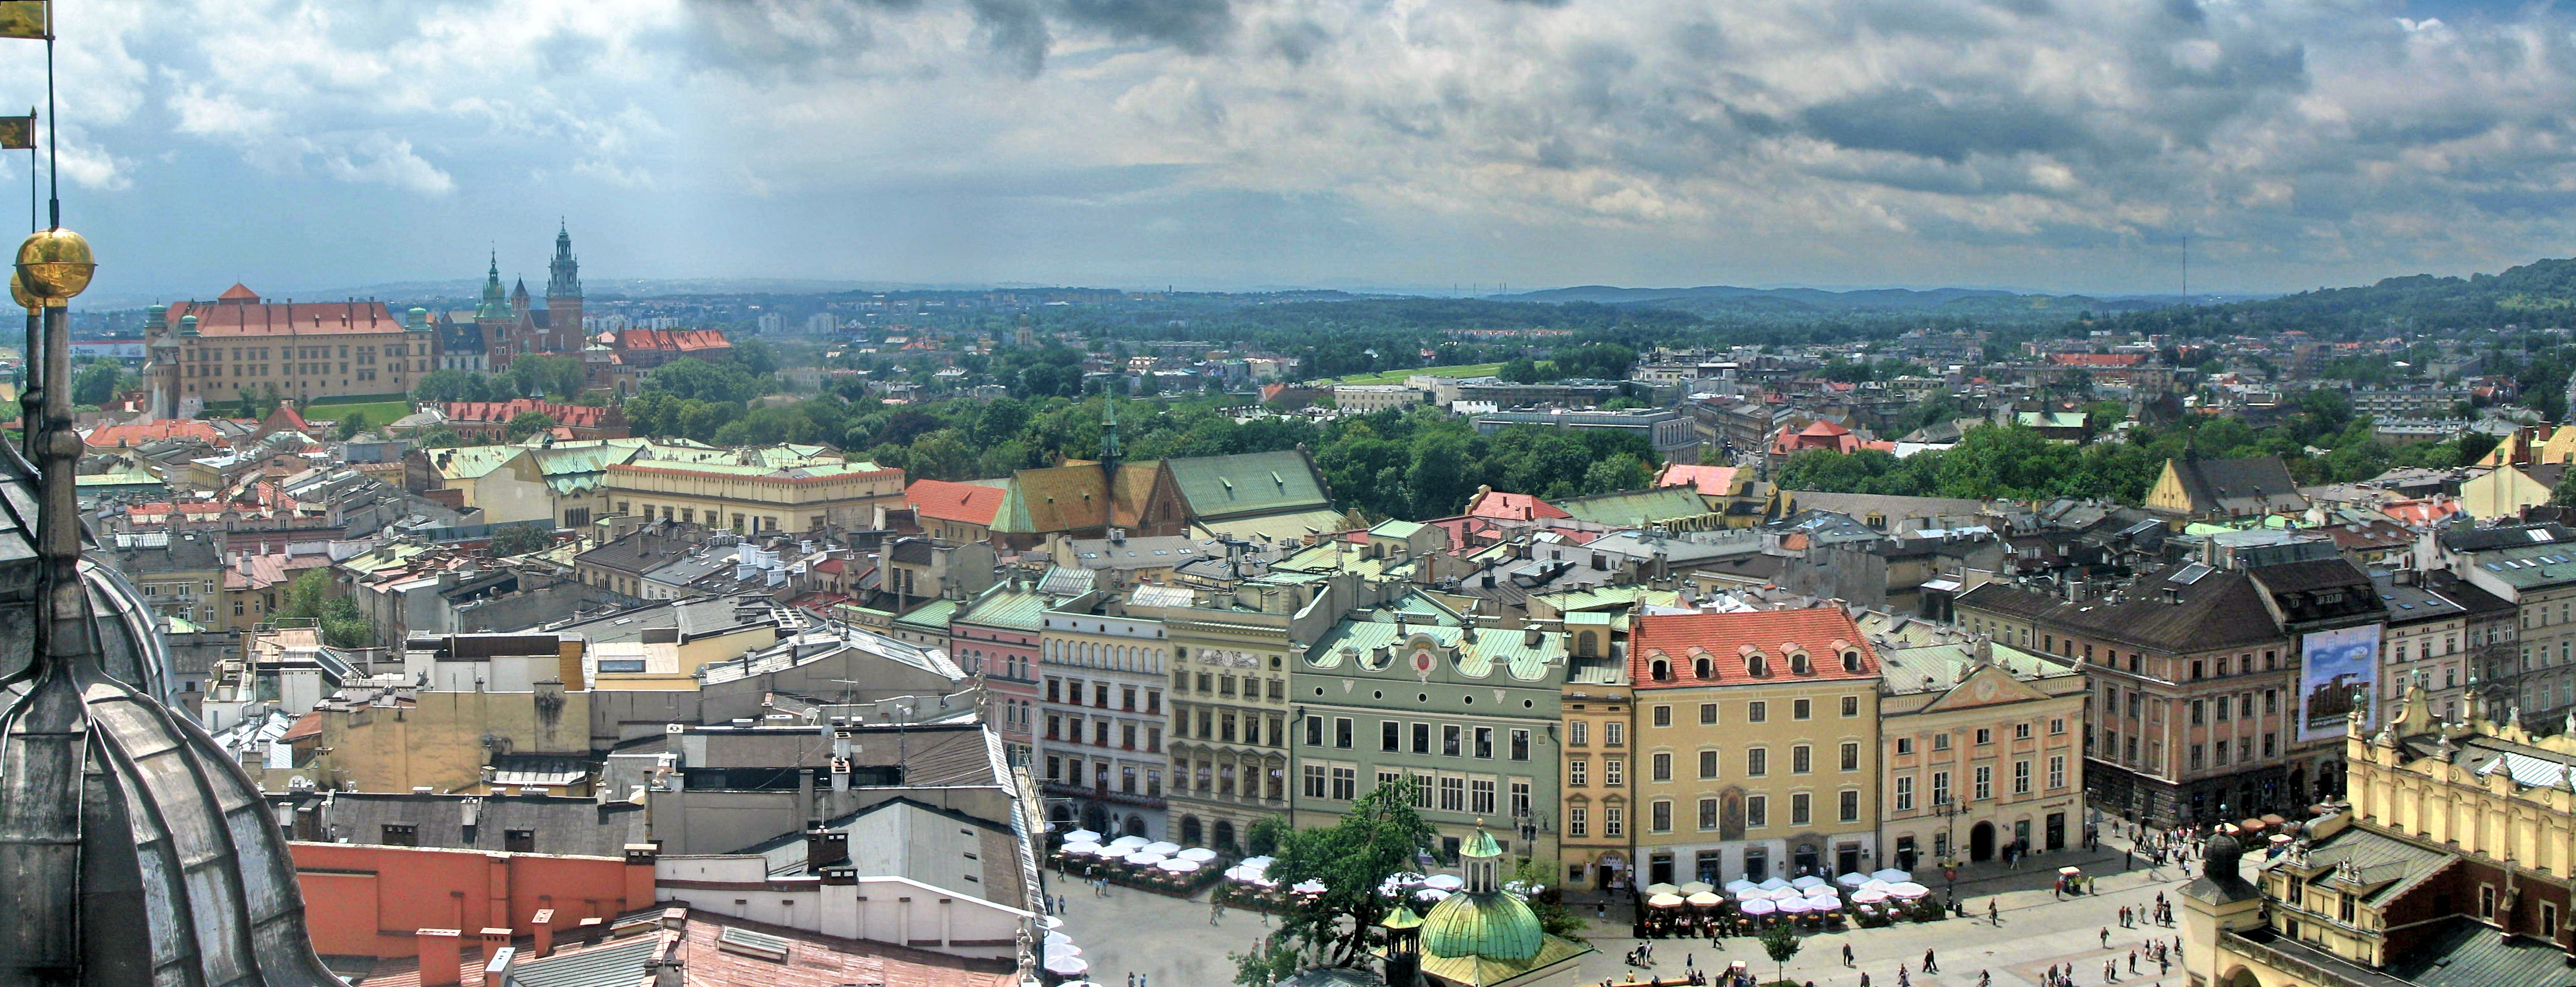

In [52]:
Image(filename=os.path.join(data_dir, 'krakow.jpg'), width=1000)

### Cracow + Van Gogh

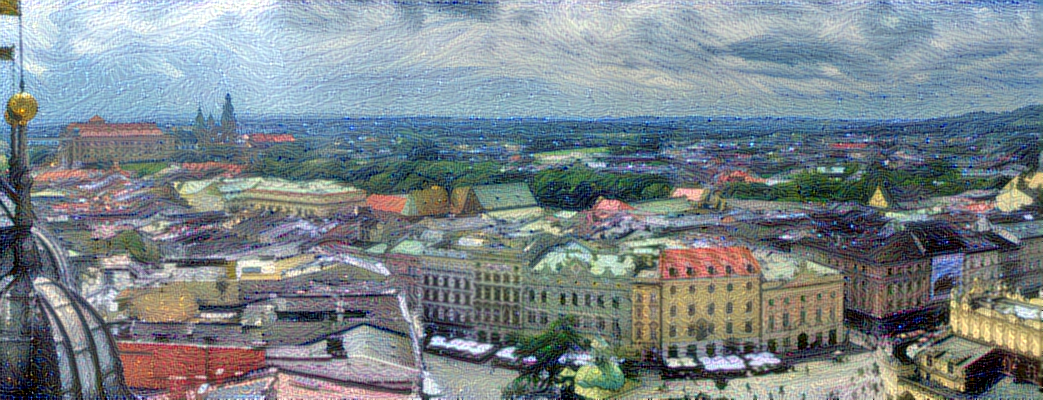

In [53]:
Image(filename=transfered_images[0], width=1000)

### Cracow + Kandinsky

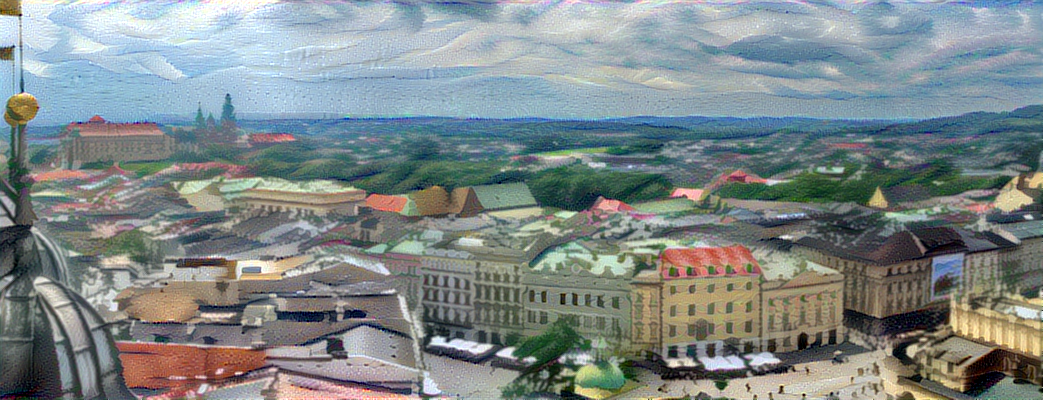

In [54]:
Image(filename=transfered_images[1], width=1000)

<HR>

<a id="summary"></a>
## 7. Summary and next steps     

 You successfully completed this notebook! You learned how to use `watson-machine-learning-client` to run experiments. Check out our [sample python web application for style transfer](https://github.com/pmservice/style-transfer).

### Citations

- <a href="https://commons.wikimedia.org/wiki/User:Rj1979">Rj1979</a>, <a href="https://commons.wikimedia.org/wiki/File:Kraków_239a.jpg">Kraków 239a</a>, marked as public domain, more details on <a href="https://commons.wikimedia.org/wiki/Template:PD-self">Wikimedia Commons</a>
- <a href="https://en.wikipedia.org/wiki/en:Vincent_van_Gogh">Vincent van Gogh</a>, <a href="https://commons.wikimedia.org/wiki/File:Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg">Van Gogh - Starry Night - Google Art Project</a>, marked as public domain, more details on <a href="https://commons.wikimedia.org/wiki/Template:PD-1923">Wikimedia Commons</a>
- <a href="https://en.wikipedia.org/wiki/en:Wassily_Kandinsky">Wassily Kandinski</a>, <a href="https://commons.wikimedia.org/wiki/File:Kandinsky,_Lyrisches.jpg">Kandinsky, Lyrisches</a>, marked as public domain, more details on <a href="https://commons.wikimedia.org/wiki/Template:PD-1923">Wikimedia Commons</a>


### Authors

**Lukasz Cmielowski**, PhD, is a Automation Architect and Data Scientist in IBM with a track record of developing enterprise-level applications that substantially increases clients' ability to turn data into actionable knowledge.

Copyright © 2018 IBM. This notebook and its source code are released under the terms of the MIT License.